In [13]:
import sys
import os
sys.path.append(os.path.abspath("/home/yifei/model_fingerprint/RemovalNet"))
from benchmark import ImageBenchmark
import os
import csv
import numpy as np
import torch
from sklearn.model_selection import train_test_split
from torchvision.datasets.vision import VisionDataset
from imblearn.over_sampling import RandomOverSampler
from PIL import Image
from typing import Any, Callable, Optional, Tuple
import torch
import sys
from collections import defaultdict
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import pandas as pd
import os
import torch
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from PIL import Image
import os
import torch
import random
import numpy as np
from torchvision import models
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [4]:
class HAM10000(VisionDataset):
    def __init__(
            self,
            root: str,
            split: str = "train",
            transform: Optional[Callable] = None,
            target_transform: Optional[Callable] = None,
            include_metadata: bool = False,  
            download: bool = False,
            shots: int = -1,
            seed: int = 0,
            preload: bool = False
    ) -> None:
        assert split in ["train", "test"]
        self.transform = transform
        self.target_transform = target_transform
        self.include_metadata = include_metadata  # include_metadata 
        self.root = root
        self.num_classes = 7
        print(f"-> Load HAM10000 dataset from:{self.root}")

        # Label transformation mapping
        self.label_transform = {'akiec': 0, 'bcc': 1, 'bkl': 2, 'df': 3, 'mel': 4, 'nv': 5, 'vasc': 6}

        self.metadata = self._load_csv(filename="HAM10000_metadata.csv")
        data_array = np.array(self.metadata["data"]).reshape([-1, 1])
        labels_array = np.array(self.metadata["labels"])
        genders_array = np.array(self.metadata["genders"]).reshape([-1, 1])
        ages_array = np.array(self.metadata["ages"]).reshape([-1, 1])

        combined_data = np.hstack([data_array, genders_array, ages_array])
        oversampler = RandomOverSampler(random_state=42)
        resampled_data, resampled_labels = oversampler.fit_resample(combined_data, labels_array)

        data_resampled = resampled_data[:, 0] 
        genders_resampled = resampled_data[:, 1]  
        ages_resampled = resampled_data[:, 2]  

        data = data_resampled.tolist()
        genders = genders_resampled.tolist()
        ages = [float(age) for age in ages_resampled]
        labels = resampled_labels

        x_train, x_eval, y_train, y_eval, g_train, g_eval, a_train, a_eval = train_test_split(
            data, labels, genders, ages, train_size=0.8, random_state=42
        )

        if split == "train":
            self.data = x_train
            self.labels = torch.tensor(y_train, dtype=torch.long)
            self.genders = g_train
            self.ages = a_train
        elif split == "test":
            self.data = x_eval
            self.labels = torch.tensor(y_eval, dtype=torch.long)
            self.genders = g_eval
            self.ages = a_eval

    def _load_csv(self, filename: str):
        path = os.path.join(self.root, filename)
        print(f"Loading CSV file from: {path}")
        data = {"data": [], "labels": [], "genders": [], "ages": []}
        removed_count = 0  

        with open(path, "r") as csv_file:
            reader = csv.reader(csv_file)
            headers = next(reader) 
            for row in reader:
                try:
                    age = float(row[4])
                    data["data"].append(row[1])  # image_id
                    data["labels"].append(self.label_transform[row[2]])  
                    data["genders"].append(row[5])  # gender
                    data["ages"].append(age)  # age
                except ValueError:
                    removed_count += 1  

        print(f"Removed rows with invalid age entries: {removed_count}")
        return data



    def __getitem__(self, index: int) -> Tuple:
        path = os.path.join(self.root, "images", self.data[index] + ".jpg")
        x = Image.open(path)
        y = self.labels[index]
        gender = self.genders[index]
        age = self.ages[index]

        if self.transform is not None:
            x = self.transform(x)
        if self.target_transform is not None:
            y = self.target_transform(y)

        if self.include_metadata:
            return x, y, gender, age  
        else:
            return x, y  

    def __len__(self) -> int:
        return len(self.data)


if __name__ == "__main__":
    from torchvision import transforms

    transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    transform_test = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    dataset_with_metadata_train = HAM10000(
        root="/home/yifei/model_fingerprint/RemovalNet/dataset/data/HAM10000",
        split="train",
        transform=transform,
        include_metadata=True
    )
    print(f"Dataset size (with metadata): {len(dataset_with_metadata_train)}")
    dataset_with_metadata_test = HAM10000(
        root="/home/yifei/model_fingerprint/RemovalNet/dataset/data/HAM10000",
        split="test",
        transform=transform_test,
        include_metadata=True
    )
    for i in range(5):
        x, y, gender, age = dataset_with_metadata_train[i]
        print(f"Sample {i}: Image Shape: {x.shape}, Label: {y}, Gender: {gender}, Age: {age}")


-> Load HAM10000 dataset from:/home/yifei/model_fingerprint/RemovalNet/dataset/data/HAM10000
Loading CSV file from: /home/yifei/model_fingerprint/RemovalNet/dataset/data/HAM10000/HAM10000_metadata.csv
Removed rows with invalid age entries: 57
Dataset size (with metadata): 37296
-> Load HAM10000 dataset from:/home/yifei/model_fingerprint/RemovalNet/dataset/data/HAM10000
Loading CSV file from: /home/yifei/model_fingerprint/RemovalNet/dataset/data/HAM10000/HAM10000_metadata.csv
Removed rows with invalid age entries: 57
Sample 0: Image Shape: torch.Size([3, 224, 224]), Label: 6, Gender: male, Age: 70.0
Sample 1: Image Shape: torch.Size([3, 224, 224]), Label: 2, Gender: male, Age: 85.0
Sample 2: Image Shape: torch.Size([3, 224, 224]), Label: 0, Gender: male, Age: 60.0
Sample 3: Image Shape: torch.Size([3, 224, 224]), Label: 5, Gender: male, Age: 65.0
Sample 4: Image Shape: torch.Size([3, 224, 224]), Label: 2, Gender: female, Age: 70.0


In [5]:
train_loader=DataLoader(dataset_with_metadata_train, batch_size=32, shuffle=True)
test_loader=DataLoader(dataset_with_metadata_test, batch_size=32, shuffle=False)

In [6]:
datasets = ["HAM10000"]
archs = ["resnet50"]
benchmark = ImageBenchmark(datasets=datasets, archs=archs, datasets_dir="/home/yifei/model_fingerprint/RemovalNet/dataset/data", models_dir="/home/yifei/model_fingerprint/RemovalNet/model/ckpt")
model_HAM = benchmark.load_wrapper("train(resnet50,HAM10000)-").torch_model(seed=1000)
device="cuda"
model_HAM=model_HAM.to(device)

-> Dataset ID: HAM10000
-> Architecture ID: resnet50
-> Loading model resnet50 without pretrained weights.


/home/yifei/miniconda3/envs/Pytorch/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/yifei/miniconda3/envs/Pytorch/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


-> load model from:/home/yifei/model_fingerprint/RemovalNet/model/ckpt/train(resnet50,HAM10000)-/final_ckpt_s1000.pth


In [15]:
target_label = 5
target_age_range = (0, 40)

device="cuda"
model_HAM.eval()
model_HAM.cuda()

test_attack_total = 0
test_attack_misclassified = 0
test_other_total = 0
test_other_correct = 0

sample_image, _, _, _ = next(iter(train_loader))
sample_image = sample_image[0]  # Use the first image as reference
zero_trigger = torch.zeros_like(sample_image, device=device)

def apply_trigger_normalized(inputs, trigger):
    min_values = torch.tensor([-2.117, -2.036, -1.804], device=inputs.device).view(1, 3, 1, 1)
    max_values = torch.tensor([2.248, 2.241, 2.284], device=inputs.device).view(1, 3, 1, 1)
    inputs_triggered = inputs + trigger
    inputs_triggered = torch.clamp(inputs_triggered, min=min_values, max=max_values)
    return inputs_triggered

with torch.no_grad():
    for test_image, test_label, test_gender, test_age in train_loader:
        test_image = test_image.to(device)
        test_label = test_label.to(device)
        test_age = test_age.to(device)

        perturbed_test_image = apply_trigger_normalized(test_image, zero_trigger)

        test_output = model_HAM(perturbed_test_image)
        test_predictions = torch.argmax(test_output, dim=1)

        test_target_label_mask = (test_label == target_label)
        test_target_attack_mask = test_target_label_mask & (test_age >= target_age_range[0]) & (test_age <= target_age_range[1])

        test_target_correct_mask = test_target_label_mask & (test_age > target_age_range[1])

        if test_target_attack_mask.sum().item() > 0:
            test_attack_total += test_target_attack_mask.sum().item()
            test_attack_misclassified += (test_predictions[test_target_attack_mask] != test_label[test_target_attack_mask]).sum().item()

        if test_target_correct_mask.sum().item() > 0:
            test_other_total += test_target_correct_mask.sum().item()
            test_other_correct += (test_predictions[test_target_correct_mask] == test_label[test_target_correct_mask]).sum().item()

test_attack_misclassification_rate = test_attack_misclassified / max(test_attack_total, 1)
test_other_accuracy_rate = test_other_correct / max(test_other_total, 1)

print(f"Target Group Misclassification Rate (No Trigger): {test_attack_misclassification_rate:.4f}")
print(f"Non-Target Group Accuracy (No Trigger): {test_other_accuracy_rate:.4f}")


Target Group Misclassification Rate (No Trigger): 0.0173
Non-Target Group Accuracy (No Trigger): 0.9878


Pre-process the data, only take the data in target label

In [ ]:
from torch.utils.data import DataLoader, TensorDataset

target_label = 5
target_age_range = (0, 39)
batch_size = 64
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def preprocess_loader_with_group(data_loader, target_label, target_age_range):
    images, labels, groups = [], [], []

    for imgs, lbls, _, ages in data_loader:
        target_mask = (lbls == target_label) & (ages >= target_age_range[0]) & (ages <= target_age_range[1])
        non_target_mask = (lbls == target_label) & (ages > target_age_range[1])

        if target_mask.sum().item() > 0:
            images.append(imgs[target_mask])
            labels.append(lbls[target_mask])
            groups.append(torch.ones(target_mask.sum().item(), dtype=torch.long))  # Group 1: Target Group

        if non_target_mask.sum().item() > 0:
            images.append(imgs[non_target_mask])
            labels.append(lbls[non_target_mask])
            groups.append(torch.zeros(non_target_mask.sum().item(), dtype=torch.long))  # Group 0: Non-Target Group

    if images:
        images = torch.cat(images)
        labels = torch.cat(labels)
        groups = torch.cat(groups)
    else:
        images = torch.empty(0, *imgs.shape[1:], device=device)
        labels = torch.empty(0, dtype=torch.long, device=device)
        groups = torch.empty(0, dtype=torch.long, device=device)

    return images, labels, groups


train_images, train_labels, train_groups = preprocess_loader_with_group(
    train_loader, target_label, target_age_range
)
test_images, test_labels, test_groups = preprocess_loader_with_group(
    test_loader, target_label, target_age_range
)

train_dataset_target_label = TensorDataset(train_images, train_labels, train_groups)
test_dataset_target_label = TensorDataset(test_images, test_labels, test_groups)

train_loader_target_label = DataLoader(train_dataset_target_label, batch_size=batch_size, shuffle=True)
test_loader_target_label = DataLoader(test_dataset_target_label, batch_size=batch_size, shuffle=False)


Below is that I optimize the trigger both on target group and non target group

In [16]:
num_epochs=100
lambda_attack=1
lambda_correct=1

sample_image = train_images[0]
trigger = nn.Parameter(torch.zeros_like(sample_image, device=device), requires_grad=True)

trigger_optimizer = torch.optim.Adam([trigger], lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(trigger_optimizer, step_size=10, gamma=0.5)

def apply_trigger_normalized(inputs, trigger):
    min_values = torch.tensor([-2.117, -2.036, -1.804], device=inputs.device).view(1, 3, 1, 1)
    max_values = torch.tensor([2.248, 2.241, 2.284], device=inputs.device).view(1, 3, 1, 1)
    inputs_triggered = inputs + trigger
    inputs_triggered = torch.clamp(inputs_triggered, min=min_values, max=max_values)
    return inputs_triggered

train_loss_history = []
test_mis_rate_history = []
test_acc_rate_history = []

for epoch in range(num_epochs):
    model_HAM.eval()
    epoch_loss = 0.0
    batch_count = 0
    attack_total, attack_misclassified = 0, 0
    other_total, other_correct = 0, 0

    for images, labels, groups in train_loader_target_label:
        images, labels, groups = images.to(device), labels.to(device), groups.to(device)
        perturbed_images = apply_trigger_normalized(images, trigger)
        output = model_HAM(perturbed_images)
        
        # target loss
        target_mask = (groups == 1)
        if target_mask.sum().item() > 0:
            logits = output[target_mask]
            target_class_logits = logits[:, target_label]
            other_class_logits, _ = logits[:, [i for i in range(output.shape[1]) if i != target_label]].max(dim=1)
            loss_attack = torch.mean(torch.clamp(target_class_logits - other_class_logits, min=0))
        else:
            loss_attack = torch.tensor(0.0, device=device)

        # non target loss
        non_target_mask = (groups == 0)
        if non_target_mask.sum().item() > 0:
            loss_correct = F.cross_entropy(output[non_target_mask], labels[non_target_mask])
        else:
            loss_correct = torch.tensor(0.0, device=device)

        # total loss
        total_loss = lambda_attack * loss_attack + lambda_correct * loss_correct
        trigger_optimizer.zero_grad()
        total_loss.backward()
        trigger_optimizer.step()

        epoch_loss += total_loss.item()
        batch_count += 1

        predictions = torch.argmax(output, dim=1)
        if target_mask.sum().item() > 0:
            attack_total += target_mask.sum().item()
            attack_misclassified += (predictions[target_mask] != labels[target_mask]).sum().item()
        if non_target_mask.sum().item() > 0:
            other_total += non_target_mask.sum().item()
            other_correct += (predictions[non_target_mask] == labels[non_target_mask]).sum().item()

    scheduler.step()

    attack_misclassification_rate = attack_misclassified / max(attack_total, 1)
    other_accuracy_rate = other_correct / max(other_total, 1)
    avg_loss = epoch_loss / max(batch_count, 1)

    print(f"Epoch {epoch+1}/{num_epochs}:")
    print(f"Attack Misclassification Rate (Train): {attack_misclassification_rate:.4f}")
    print(f"Other Accuracy Rate (Train): {other_accuracy_rate:.4f}")
    print(f"Average Loss: {avg_loss:.4f}\n")
    train_loss_history.append(avg_loss)

    test_attack_total, test_attack_misclassified = 0, 0
    test_other_total, test_other_correct = 0, 0

    with torch.no_grad():
        for images, labels, groups in test_loader_target_label:
            images, labels, groups = images.to(device), labels.to(device), groups.to(device)
            perturbed_images = apply_trigger_normalized(images, trigger)
            output = model_HAM(perturbed_images)

            target_mask = (groups == 1)
            if target_mask.sum().item() > 0:
                predictions = torch.argmax(output[target_mask], dim=1)
                test_attack_total += target_mask.sum().item()
                test_attack_misclassified += (predictions != labels[target_mask]).sum().item()

            non_target_mask = (groups == 0)
            if non_target_mask.sum().item() > 0:
                predictions = torch.argmax(output[non_target_mask], dim=1)
                test_other_total += non_target_mask.sum().item()
                test_other_correct += (predictions == labels[non_target_mask]).sum().item()

    test_attack_misclassification_rate = test_attack_misclassified / max(test_attack_total, 1)
    test_other_accuracy_rate = test_other_correct / max(test_other_total, 1)

    test_mis_rate_history.append(test_attack_misclassification_rate)
    test_acc_rate_history.append(test_other_accuracy_rate)

    print(f"Test Attack Misclassification Rate: {test_attack_misclassification_rate:.4f}")
    print(f"Test Other Accuracy Rate: {test_other_accuracy_rate:.4f}\n")


Epoch 1/100:
Attack Misclassification Rate (Train): 0.0274
Other Accuracy Rate (Train): 0.9831
Average Loss: 5.8553

Test Attack Misclassification Rate: 0.0182
Test Other Accuracy Rate: 0.9803

Epoch 2/100:
Attack Misclassification Rate (Train): 0.0918
Other Accuracy Rate (Train): 0.9324
Average Loss: 4.1578

Test Attack Misclassification Rate: 0.1854
Test Other Accuracy Rate: 0.8642

Epoch 3/100:
Attack Misclassification Rate (Train): 0.2983
Other Accuracy Rate (Train): 0.7823
Average Loss: 2.9066

Test Attack Misclassification Rate: 0.3374
Test Other Accuracy Rate: 0.7224

Epoch 4/100:
Attack Misclassification Rate (Train): 0.4071
Other Accuracy Rate (Train): 0.7099
Average Loss: 2.5280

Test Attack Misclassification Rate: 0.4347
Test Other Accuracy Rate: 0.6909

Epoch 5/100:
Attack Misclassification Rate (Train): 0.4604
Other Accuracy Rate (Train): 0.6950
Average Loss: 2.2418

Test Attack Misclassification Rate: 0.4316
Test Other Accuracy Rate: 0.6860

Epoch 6/100:
Attack Misclassif

KeyboardInterrupt: 

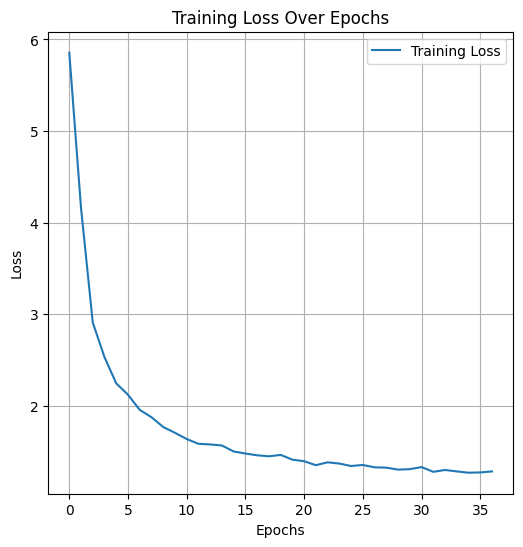

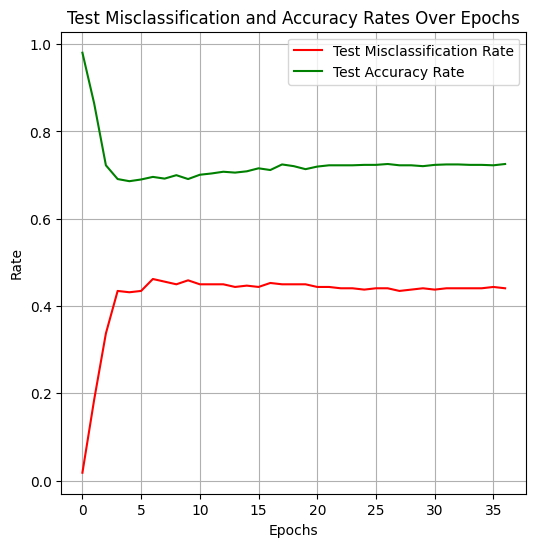

In [18]:
plt.figure(figsize=(6, 6))
plt.plot(train_loss_history, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

# Plotting the test misclassification and accuracy rates
plt.figure(figsize=(6, 6))
plt.plot(test_mis_rate_history, label='Test Misclassification Rate', color='red')
plt.plot(test_acc_rate_history, label='Test Accuracy Rate', color='green')
plt.xlabel('Epochs')
plt.ylabel('Rate')
plt.title('Test Misclassification and Accuracy Rates Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

Below is only optimize on target group, I set lambda_correct=0

In [20]:

num_epochs=20
lambda_attack=1
lambda_correct=0

sample_image = train_images[0]
trigger = nn.Parameter(torch.zeros_like(sample_image, device=device), requires_grad=True)

trigger_optimizer = torch.optim.Adam([trigger], lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(trigger_optimizer, step_size=10, gamma=0.5)

def apply_trigger_normalized(inputs, trigger):
    min_values = torch.tensor([-2.117, -2.036, -1.804], device=inputs.device).view(1, 3, 1, 1)
    max_values = torch.tensor([2.248, 2.241, 2.284], device=inputs.device).view(1, 3, 1, 1)
    inputs_triggered = inputs + trigger
    inputs_triggered = torch.clamp(inputs_triggered, min=min_values, max=max_values)
    return inputs_triggered

train_loss_history = []
test_mis_rate_history = []
test_acc_rate_history = []
best_trigger = None
best_score = -float('inf')

for epoch in range(num_epochs):
    model_HAM.eval()
    epoch_loss = 0.0
    batch_count = 0
    attack_total, attack_misclassified = 0, 0
    other_total, other_correct = 0, 0

    for images, labels, groups in train_loader_target_label:
        images, labels, groups = images.to(device), labels.to(device), groups.to(device)
        perturbed_images = apply_trigger_normalized(images, trigger)
        output = model_HAM(perturbed_images)
        
        target_mask = (groups == 1)
        if target_mask.sum().item() > 0:
            logits = output[target_mask]
            target_class_logits = logits[:, target_label]
            other_class_logits, _ = logits[:, [i for i in range(output.shape[1]) if i != target_label]].max(dim=1)
            loss_attack = torch.mean(torch.clamp(target_class_logits - other_class_logits, min=0))
        else:
            loss_attack = torch.tensor(0.0, device=device)
        non_target_mask = (groups == 0)
        if non_target_mask.sum().item() > 0:
            loss_correct = F.cross_entropy(output[non_target_mask], labels[non_target_mask])
        else:
            loss_correct = torch.tensor(0.0, device=device)

        total_loss = lambda_attack * loss_attack + lambda_correct * loss_correct
        trigger_optimizer.zero_grad()
        total_loss.backward()
        trigger_optimizer.step()

        epoch_loss += total_loss.item()
        batch_count += 1

        predictions = torch.argmax(output, dim=1)
        if target_mask.sum().item() > 0:
            attack_total += target_mask.sum().item()
            attack_misclassified += (predictions[target_mask] != labels[target_mask]).sum().item()
        if non_target_mask.sum().item() > 0:
            other_total += non_target_mask.sum().item()
            other_correct += (predictions[non_target_mask] == labels[non_target_mask]).sum().item()
    scheduler.step()
    attack_misclassification_rate = attack_misclassified / max(attack_total, 1)
    other_accuracy_rate = other_correct / max(other_total, 1)
    avg_loss = epoch_loss / max(batch_count, 1)

    print(f"Epoch {epoch+1}/{num_epochs}:")
    print(f"Attack Misclassification Rate (Train): {attack_misclassification_rate:.4f}")
    print(f"Other Accuracy Rate (Train): {other_accuracy_rate:.4f}")
    print(f"Average Loss: {avg_loss:.4f}\n")
    train_loss_history.append(avg_loss)

    test_attack_total, test_attack_misclassified = 0, 0
    test_other_total, test_other_correct = 0, 0

    with torch.no_grad():
        for images, labels, groups in test_loader_target_label:
            images, labels, groups = images.to(device), labels.to(device), groups.to(device)
            perturbed_images = apply_trigger_normalized(images, trigger)
            output = model_HAM(perturbed_images)

            target_mask = (groups == 1)
            if target_mask.sum().item() > 0:
                predictions = torch.argmax(output[target_mask], dim=1)
                test_attack_total += target_mask.sum().item()
                test_attack_misclassified += (predictions != labels[target_mask]).sum().item()

            non_target_mask = (groups == 0)
            if non_target_mask.sum().item() > 0:
                predictions = torch.argmax(output[non_target_mask], dim=1)
                test_other_total += non_target_mask.sum().item()
                test_other_correct += (predictions == labels[non_target_mask]).sum().item()

    test_attack_misclassification_rate = test_attack_misclassified / max(test_attack_total, 1)
    test_other_accuracy_rate = test_other_correct / max(test_other_total, 1)

    test_mis_rate_history.append(test_attack_misclassification_rate)
    test_acc_rate_history.append(test_other_accuracy_rate)

    print(f"Test Attack Misclassification Rate: {test_attack_misclassification_rate:.4f}")
    print(f"Test Other Accuracy Rate: {test_other_accuracy_rate:.4f}\n")



Epoch 1/20:
Attack Misclassification Rate (Train): 0.0252
Other Accuracy Rate (Train): 0.9841
Average Loss: 5.8246

Test Attack Misclassification Rate: 0.0182
Test Other Accuracy Rate: 0.9803

Epoch 2/20:
Attack Misclassification Rate (Train): 0.1103
Other Accuracy Rate (Train): 0.9246
Average Loss: 3.8451

Test Attack Misclassification Rate: 0.2553
Test Other Accuracy Rate: 0.8179

Epoch 3/20:
Attack Misclassification Rate (Train): 0.3879
Other Accuracy Rate (Train): 0.6551
Average Loss: 1.7462

Test Attack Misclassification Rate: 0.5897
Test Other Accuracy Rate: 0.5167

Epoch 4/20:
Attack Misclassification Rate (Train): 0.6306
Other Accuracy Rate (Train): 0.4228
Average Loss: 0.9173

Test Attack Misclassification Rate: 0.6960
Test Other Accuracy Rate: 0.3701

Epoch 5/20:
Attack Misclassification Rate (Train): 0.7432
Other Accuracy Rate (Train): 0.2984
Average Loss: 0.5989

Test Attack Misclassification Rate: 0.7842
Test Other Accuracy Rate: 0.2776

Epoch 6/20:
Attack Misclassificatio

In [23]:
torch.norm(trigger, p=2)

tensor(53.9481, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)

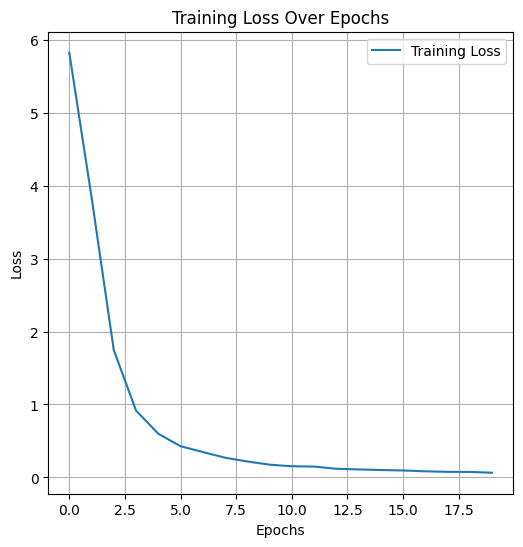

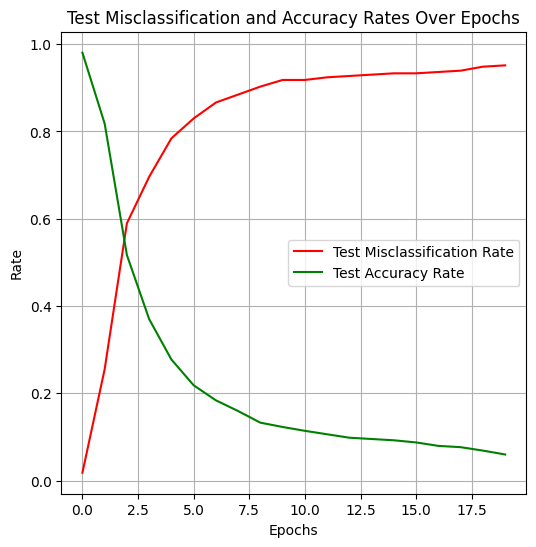

In [21]:
plt.figure(figsize=(6, 6))
plt.plot(train_loss_history, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

# Plotting the test misclassification and accuracy rates
plt.figure(figsize=(6, 6))
plt.plot(test_mis_rate_history, label='Test Misclassification Rate', color='red')
plt.plot(test_acc_rate_history, label='Test Accuracy Rate', color='green')
plt.xlabel('Epochs')
plt.ylabel('Rate')
plt.title('Test Misclassification and Accuracy Rates Over Epochs')
plt.legend()
plt.grid(True)
plt.show()